# Driver Aggression Neural Network (DANN)

Driver Aggression Neural Network is assigning an aggression value to a sorted set of sensory data. Driving is simulated in BeamNG v0.27 using their BeamNGpy open-source library.

In [ ]:
import pandas as pd
import torch
import glob
import uuid

parquet_file_path = '../imu_data*.parquet'
file_list = glob.glob(parquet_file_path)

# Initialize an empty list to hold the dataframes
df_list = []
# Loop through the file list and read each file into a dataframe
for file in file_list:
    df = pd.read_parquet(file)
    # Assign UUID to imuId
    # create a dictionary that maps each unique imuId to a random UUID
    uuid_dict = {imuId: str(uuid.uuid4()) for imuId in df['imuId'].unique()}
    # replace imuId values using the dictionary
    df['imuId'] = df['imuId'].map(uuid_dict)
    df_list.append(df)

# Concatenate all the dataframes into a single dataframe
data = pd.concat(df_list, ignore_index=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Modify training data

- Group together data recorded from the same sensor
- Take around 100-1000 recorded data without the aggression values
- Make aggression values the label of the dataset
- Create a lot of training data by chunking the sorted (by timestamp) records.

C:\Users\illya\AppData\Local\Temp\ipykernel_7588\4117678759.py:123: FutureWarning: column_space is deprecated and will be removed in a future version. Use df.to_string(col_space=...) instead.
  pd.reset_option("all")
C:\Users\illya\AppData\Local\Temp\ipykernel_7588\4117678759.py:123: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  pd.reset_option("all")
C:\Users\illya\AppData\Local\Temp\ipykernel_7588\4117678759.py:123: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  pd.reset_option("all")


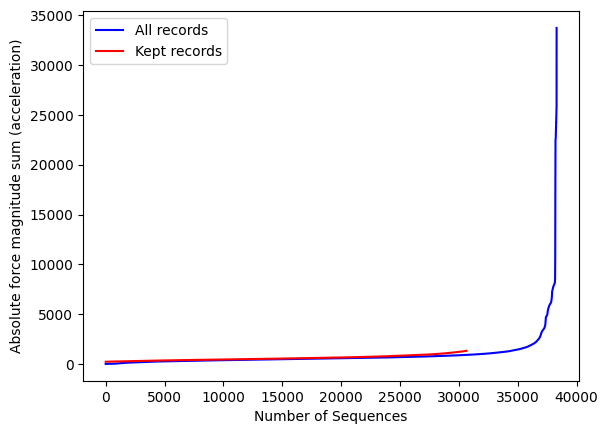

In [181]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Assuming 'data' is your Scheme
# data = pd.DataFrame(columns=[
#     'imuId',
#     'vehicleAggression',
#     'time',
#     'pos',
#     'dirX',
#     'dirY',
#     'dirZ',
#     'angVel',
#     'angAccel',
#     'mass',
#     'accRaw',
#     'accSmooth'
# ])

# Function to split the data into chunks
def split_into_chunks(data, chunk_size):
    return [data[i:i+chunk_size] for i in range(0, len(data), chunk_size)]

def remove_volatile_records(training_data, trim_start=0.2, trim_end=0.0):
    # Calculate the sum of force magnitude for each sequence
    chosen_index = random.randint(0, len(training_data) - 1)
    for index, item in enumerate(training_data):
        data = item['data']
        data['forceMagnitude'] = np.linalg.norm(data[['accSmoothX', 'accSmoothY', 'accSmoothZ']], axis=1)
        # Plot the force magnitudes for a random sequence
        # if index == chosen_index:
        #     plt.plot(data['forceMagnitude'])
        #     plt.show()
        item['forceSum'] = data['forceMagnitude'].sum()
        data.drop('forceMagnitude', axis=1, inplace=True)

    # Sort the sequences by the sum of force magnitude
    training_data.sort(key=lambda x: x['forceSum'], reverse=False)

    # Keep only the most volatile top% of the sequences
    trimmed_start = int(len(training_data) * trim_start)
    trimmed_end = int(len(training_data) * (1 - trim_end))
    
    # Plot the force magnitude sum for each sequence
    plt.plot([item['forceSum'] for item in training_data], label='All records', color='blue')
    plt.ylabel('Absolute force magnitude sum (acceleration)')
    plt.xlabel('Number of Sequences')
    
    # Plot the force magnitude sum for each sequence after cutoff with label
    plt.plot([item['forceSum'] for item in training_data[trimmed_start:trimmed_end]], label='Kept records', color='red')
    plt.legend()
    
    return pd.DataFrame(training_data[trimmed_start:trimmed_end])

# Group the data by 'imuId' and sort within each group by 'time'
grouped_data = data.groupby('imuId').apply(lambda x: x.sort_values('time')).reset_index(drop=True)

# Set the desired chunk size (number of records per chunk)
chunk_size = 100

# Split the data into chunks and assign the 'vehicleAggression' value as the label
training_data = []
for imu_id, group in grouped_data.groupby('imuId'):
    group.dropna()
    chunks = split_into_chunks(group, chunk_size)
    for chunk in chunks:
        if len(chunk) >= chunk_size:
            label = chunk['vehicleAggression'].iloc[0]
            first_timestamp = chunk['time'].iloc[0]
            adjusted_time = chunk['time'] - first_timestamp
            
            # Separate list columns into individual columns
            pos_df = pd.DataFrame(chunk['pos'].tolist(), columns=['posX', 'posY', 'posZ'], index=chunk.index)
            dir_x_df = pd.DataFrame(chunk['dirX'].tolist(), columns=['dirXX', 'dirXY', 'dirXZ'], index=chunk.index)
            dir_y_df = pd.DataFrame(chunk['dirY'].tolist(), columns=['dirYX', 'dirYY', 'dirYZ'], index=chunk.index)
            dir_z_df = pd.DataFrame(chunk['dirZ'].tolist(), columns=['dirZX', 'dirZY', 'dirZZ'], index=chunk.index)
            acc_raw_df = pd.DataFrame(chunk['accRaw'].tolist(), columns=['accRawX', 'accRawY', 'accRawZ'], index=chunk.index)
            acc_smooth_df = pd.DataFrame(chunk['accSmooth'].tolist(), columns=['accSmoothX', 'accSmoothY', 'accSmoothZ'], index=chunk.index)
            ang_vel_df = pd.DataFrame(chunk['angVel'].tolist(), columns=['angVelX', 'angVelY', 'angVelZ'], index=chunk.index)
            ang_accel_df = pd.DataFrame(chunk['angAccel'].tolist(), columns=['angAccelX', 'angAccelY', 'angAccelZ'], index=chunk.index)
            
            expanded_chunk = pd.concat(
                [
                    chunk,
                    pos_df,
                    dir_x_df,
                    dir_y_df,
                    dir_z_df,
                    acc_raw_df,
                    acc_smooth_df,
                    ang_vel_df,
                    ang_accel_df
                ],
                axis=1
            )
            
            updated_chunk = (
                expanded_chunk.assign(time=adjusted_time)
                .drop(['imuId', 'mass', 'vehicleAggression', 'pos', 'dirX', 'dirY', 'dirZ', 'angVel', 'angAccel', 'accRaw', 'accSmooth'], axis=1)
            )
            
            training_data.append({'data': updated_chunk, 'label': label})

# Remove records with identical rows
training_data = [item for item in training_data if not item['data'].duplicated().any()]

# Keep the most volatile records (based on force magnitude)
trim_low_acceleration_records = 0.1 # default 0.2
trim_volatile_records = 0.1 # default 0.05

# Remove the most volatile records from the training data
training_data_df = remove_volatile_records(training_data, trim_start=trim_low_acceleration_records, trim_end=trim_volatile_records)

# Example of a single training set
# Set display options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", 100)  # Set the maximum column width to 100 characters
pd.set_option("display.expand_frame_repr", False)
# print(training_data_df.loc[0, 'data'])
pd.reset_option("all")


## Translating the training data to learn

In [182]:
from sklearn.model_selection import train_test_split

# Get the data and labels from the training_data_df
X = np.stack(training_data_df['data'].apply(lambda x: x.to_numpy()).to_numpy())
y = training_data_df['label'].to_numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (24512, 100, 25)
X_test shape: (6128, 100, 25)
y_train shape: (24512,)
y_test shape: (6128,)


## Learn with PyTorch

- Create a TensorDataset
- Create a DataLoader, which shuffles the data
- Create a simple neural net (torch.nn.Sequential) which uses CUDA while training
- Train the neural net with the data provided
- Evaluate the net with the test data

In [183]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)
X_train_rnn = X_train.reshape(-1, X_train.shape[1], X_train.shape[2])
X_test_rnn = X_test.reshape(-1, X_test.shape[1], X_test.shape[2])
print("X_train_2d shape:", X_train_2d.shape)
print("X_test_2d shape:", X_test_2d.shape)
print("X_train_rnn shape:", X_train_rnn.shape)
print("X_test_rnn shape:", X_test_rnn.shape)

# Create tensors from the padded data
X_train_tensor = torch.tensor(X_train).to(device)
X_train_tensor_2d = torch.tensor(X_train_2d).to(device)
y_train_tensor = torch.tensor(y_train).to(device)
X_test_tensor = torch.tensor(X_test).to(device)
X_test_tensor_2d = torch.tensor(X_test_2d).to(device)
y_test_tensor = torch.tensor(y_test).to(device)

# Create a DataLoader for the training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataset_2d = TensorDataset(X_train_tensor_2d, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataset_2d = TensorDataset(X_test_tensor_2d, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_2d = DataLoader(train_dataset_2d, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
test_loader_2d = DataLoader(test_dataset_2d, batch_size=batch_size)

rnn_batch_size = 32 # Use for RNN
X_train_tensor_rnn = torch.tensor(X_train_rnn).to(device)
X_test_tensor_rnn = torch.tensor(X_test_rnn).to(device)
rnn_train_dataset = TensorDataset(X_train_tensor_rnn, y_train_tensor)
rnn_test_dataset = TensorDataset(X_test_tensor_rnn, y_test_tensor)
rnn_train_loader = DataLoader(rnn_train_dataset, batch_size=rnn_batch_size, shuffle=True)
rnn_test_loader = DataLoader(rnn_test_dataset, batch_size=rnn_batch_size)

X_train_2d shape: (24512, 2500)
X_test_2d shape: (6128, 2500)
X_train_rnn shape: (24512, 100, 25)
X_test_rnn shape: (6128, 100, 25)


In [201]:
def plot_evaluation(actuals: list[float], predictions: list[float]):
    # Sort actuals and predictions by actuals
    actuals, predictions = zip(*sorted(zip(actuals, predictions)))
    
    # Plot the predictions vs actuals
    plt.figure(figsize=(12, 6))
    plt.title('Predictions vs Actuals (sorted by actuals)')
    plt.plot(actuals, label='Actuals', linestyle='dashed', alpha=0.2, color='blue')
    plt.plot(predictions, label='Predictions', linestyle='dashed', alpha=0.2, linewidth=2, color='red')
    plt.ylabel('Vehicle Aggression')
    plt.xlabel('Predictions')
    plt.legend()
    
    # Create a subplot for linear regression
    # Your array
    y_actuals = np.array(actuals)
    y_predictions = np.array(predictions)
    # Get the indices of the array
    x = np.arange(len(y_actuals))
    # Calculate the coefficients of the linear regression
    slope_actuals, intercept_actuals = np.polyfit(x, y_actuals, 1)
    slope_predictions, intercept_predictions = np.polyfit(x, y_predictions, 1)
    # Create the line for the regression
    regression_line_actuals = slope_actuals * x + intercept_actuals
    regression_line_predictions = slope_predictions * x + intercept_predictions
    # Plot the regression line
    plt.plot(x, regression_line_actuals, color='blue', label='Actuals Linear Regression')
    plt.plot(x, regression_line_predictions, color='red', label='Predictions Linear Regression')
    plt.legend()
    plt.show()
    
def plot_evaluations(actuals: list[float], predictions: dict[str, list[float]]):
    plt.figure(figsize=(12, 6))
    plt.title('Predictions vs Actuals (sorted by actuals)')
    plt.ylabel('Vehicle Aggression')
    plt.xlabel('Predictions')
    # Create mapping of new indices of sorted actuals to original indices
    sorted_indices = sorted(range(len(actuals)), key=lambda k: actuals[k])
    actuals = sorted(actuals)
    # Sort each prediction based on sorted_indices
    sorted_predictions = {}
    for model, prediction in predictions.items():
        sorted_predictions[model] = [prediction[index] for index in sorted_indices]
    
    # Plot the predictions
    x = np.arange(len(actuals))
    for model, prediction in sorted_predictions.items():
        plt.plot(prediction, label=model, linestyle='dashed', alpha=0.2, linewidth=2)
        
    # Plot the actuals
    plt.plot(actuals, label='Actuals', linestyle='dashed', alpha=0.2, color='blue')
    
    # Plot the predictions linear regression
    for model, prediction in sorted_predictions.items():
        y_predictions = np.array(prediction)
        slope_predictions, intercept_predictions = np.polyfit(x, y_predictions, 1)
        regression_line_predictions = slope_predictions * x + intercept_predictions
        plt.plot(x, regression_line_predictions, label=f'{model} Linear Regression')

    # Plot the actuals linear regression
    y_actuals = np.array(actuals)
    slope_actuals, intercept_actuals = np.polyfit(x, y_actuals, 1)
    regression_line_actuals = slope_actuals * x + intercept_actuals
    plt.plot(x, regression_line_actuals, color='blue', label='Actuals Linear Regression')
    
    # Limit y axis to min-10% and max+10% actuals interval
    actuals_y_length = max(actuals) - min(actuals)
    plt.ylim(min(actuals) - 0.1 * actuals_y_length, max(actuals) + 0.1 * actuals_y_length)
    plt.legend()
    plt.show()
    
def plot_train(loss_at_epoch: list[float]):
    plt.plot(loss_at_epoch, label='Training loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
def plot_trains(losses_at_epoch: dict[str, list[float]]):
    for model, loss_at_epoch in losses_at_epoch.items():
        x_values = range(len(loss_at_epoch))
        x_values = [x / max(x_values) for x in x_values]  # Normalize x values to [0, 1] range
        plt.plot(x_values, loss_at_epoch, label=model)
    plt.ylabel('Loss')
    plt.xlabel('Training Progress')
    # Limit y axis max to the first epoch's min loss+10% where loss_at_epoch is not empty
    not_empty_losses_at_epoch = [loss_at_epoch for loss_at_epoch in losses_at_epoch.values() if len(loss_at_epoch) > 0]
    plt.ylim(top=min([loss_at_epoch[0] for loss_at_epoch in not_empty_losses_at_epoch]))
    plt.ylim(bottom=0)
    plt.legend()
    plt.show()
    
def plot_train_efficiencies(losses: dict[str, float], training_times: dict[str, float]):
    # Plot 1 / (loss * training_time) for each model with bar chart
    plt.bar(losses.keys(), [1 / (loss * training_times[model]) for model, loss in losses.items()])
    plt.ylabel('Efficiency (1 / (loss * training time))')
    plt.xlabel('Models')

In [185]:
from sklearn.metrics import mean_squared_error

best_of_models = {}
calculate_loss = mean_squared_error

def add_best_of_model(
    model: str,
    predictions: list[float],
    loss_at_epoch: list[float] = [],
    training_time: float = 0.0,
    hyperparameters: dict = {}):
    global best_of_models
    best_of_models[model] = {
        'predictions': predictions,
        'loss': calculate_loss(y_test, predictions),
        'loss_at_epoch': loss_at_epoch,
        'training_time': training_time,
        'hyperparameters': hyperparameters,
        }

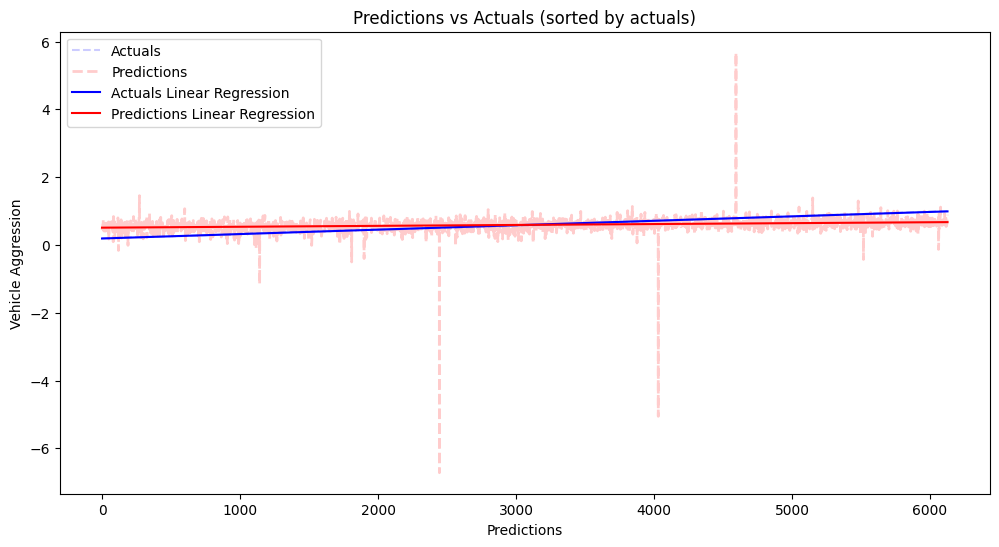

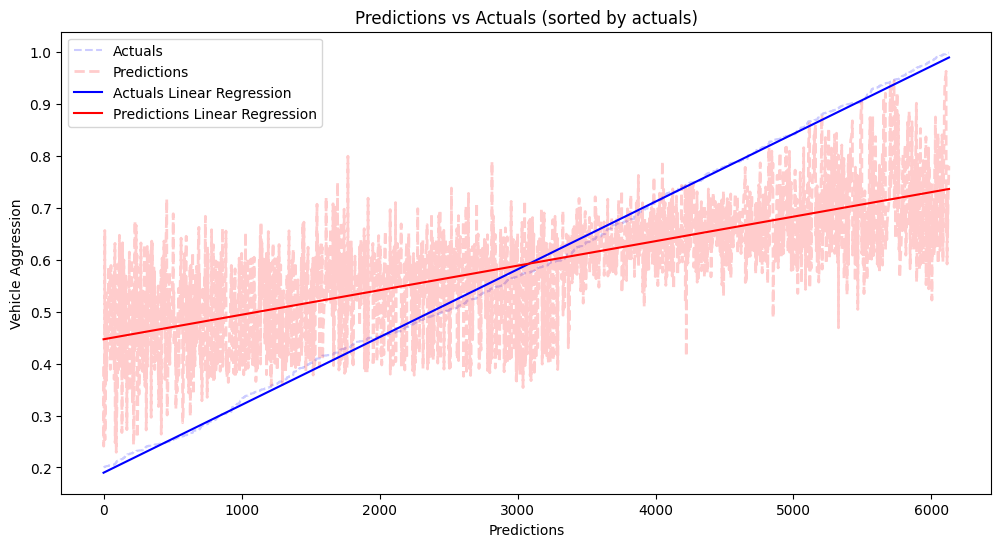

c:\Users\illya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


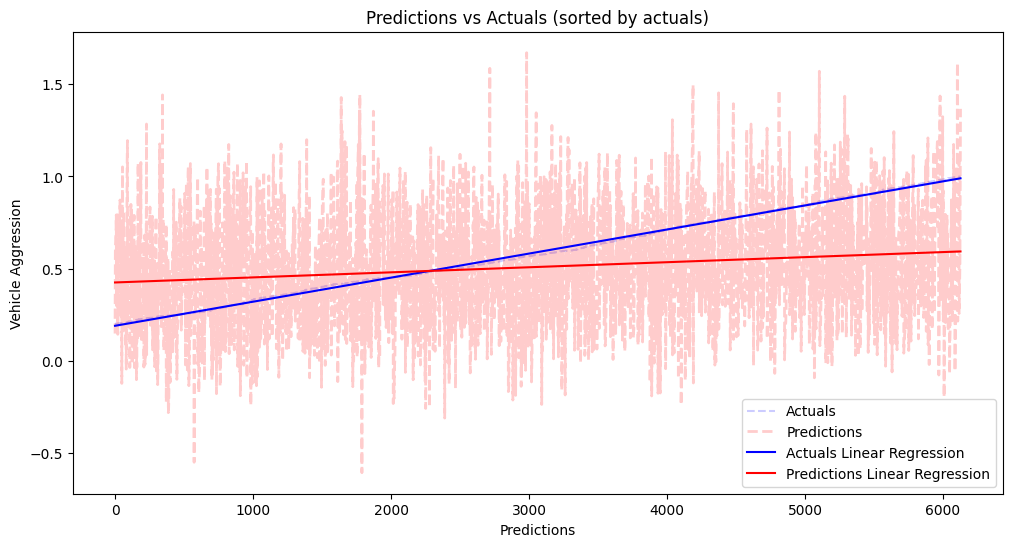

Linear Regression: MSE = 0.0673, R2 = -0.2596
Random Forest: MSE = 0.0272, R2 = 0.4914
Support Vector Regression: MSE = 0.1194, R2 = -1.2336


In [186]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR 
from sklearn.metrics import mean_squared_error, r2_score
import time

# Linear Regression
lr = LinearRegression()
time_start = time.perf_counter()
lr.fit(X_train_2d, y_train)
time_end = time.perf_counter()
y_pred_lr = lr.predict(X_test_2d)
plot_evaluation(y_test, y_pred_lr)
add_best_of_model('Linear Regression', y_pred_lr, training_time=time_end-time_start)

# Random Forest
n_estimators = 200
random_state = 42
rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state, n_jobs=-1)
# Start timer
time_start = time.perf_counter()
rf.fit(X_train_2d, y_train)
time_end = time.perf_counter()
y_pred_rf = rf.predict(X_test_2d)
plot_evaluation(y_test, y_pred_rf)
add_best_of_model('Random Forest', y_pred_rf, training_time=time_end-time_start, hyperparameters={'n_estimators': n_estimators, 'random_state': random_state})

# Support Vector Regression
max_iter = 10000
svr = LinearSVR(max_iter=max_iter)
time_start = time.perf_counter()
svr.fit(X_train_2d, y_train)
time_end = time.perf_counter()
y_pred_svr = svr.predict(X_test_2d)
plot_evaluation(y_test, y_pred_svr)
add_best_of_model('Linear SVR', y_pred_svr, training_time=time_end-time_start, hyperparameters={'max_iter': max_iter})

# Evaluation
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("Linear Regression: MSE = {:.4f}, R2 = {:.4f}".format(mse_lr, r2_lr))
print("Random Forest: MSE = {:.4f}, R2 = {:.4f}".format(mse_rf, r2_rf))
print("Support Vector Regression: MSE = {:.4f}, R2 = {:.4f}".format(mse_svr, r2_svr))


In [187]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import optuna
from random import choice

# Prepare the dataset
train_data = lgb.Dataset(X_train_2d, label=y_train, free_raw_data=False)
test_data = lgb.Dataset(X_test_2d, label=y_test, reference=train_data, free_raw_data=False)

def train_and_eval_lgb(
    boosting_type: str = 'gbdt',
    early_stopping_rounds: int = 50,
    num_boost_round: int = 2000,
    learning_rate: float = None):
    # Set up the model parameters
    params = {
        'boosting_type': boosting_type,
        'objective': 'regression',
        'metric': 'mse',
        'device_type': 'gpu',
        'n_jobs': -1,
        'early_stopping_rounds': early_stopping_rounds,
        'num_boost_round': num_boost_round,
    }
    if learning_rate is not None:
        params['learning_rate'] = learning_rate
    
    evals_result = {}

    # Train the model
    callback = lgb.record_evaluation(evals_result)
    time_start = time.perf_counter()
    gbm = lgb.train(params, train_data, valid_sets=test_data, callbacks=[callback])
    time_end = time.perf_counter()
    duration = time_end - time_start

    # Make predictions
    y_pred_lgb = gbm.predict(X_test_2d)

    return evals_result, y_pred_lgb, duration, params

results = {}
for boosting_type in ['gbdt', 'dart', 'goss']:
    results[boosting_type] = train_and_eval_lgb(boosting_type)

for type, result in results.items():
    mse_lgb = mean_squared_error(y_test, result[1])
    mae_lgb = mean_absolute_error(y_test, result[1])
    r2_lgb = r2_score(y_test, result[1])
    print("LightGBM {} Regression: MSE = {:.4f}, R2 = {:.4f}, MAE = {:.4f}".format(type, mse_lgb, r2_lgb, mae_lgb))

c:\Users\illya\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 637245
[LightGBM] [Info] Number of data points in the train set: 24512, number of used features: 2499
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 2499 dense feature groups (58.44 MB) transferred to GPU in 0.060131 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.594048
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 637245
[LightGBM] [Info] Number of data points in the train set: 24512, number of used features: 2499
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entr

c:\Users\illya\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 637245
[LightGBM] [Info] Number of data points in the train set: 24512, number of used features: 2499
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 2499 dense feature groups (58.44 MB) transferred to GPU in 0.048807 secs. 0 sparse feature groups
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.594048
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 2499 dense feature groups (17.47 MB) transferred to GPU in 0.045420 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 2499 dense feature groups (17.47 MB) transferred to GPU in 0.045948 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[Ligh

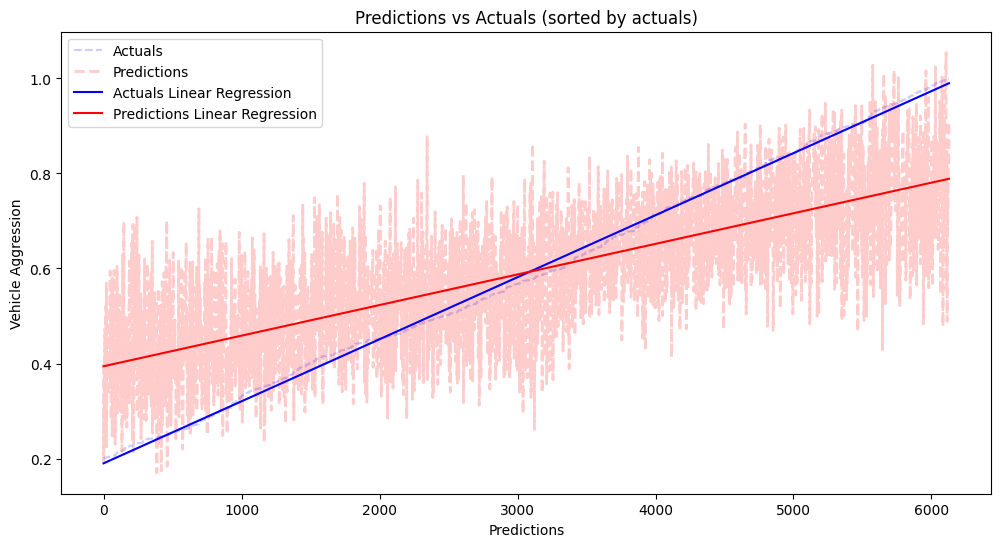

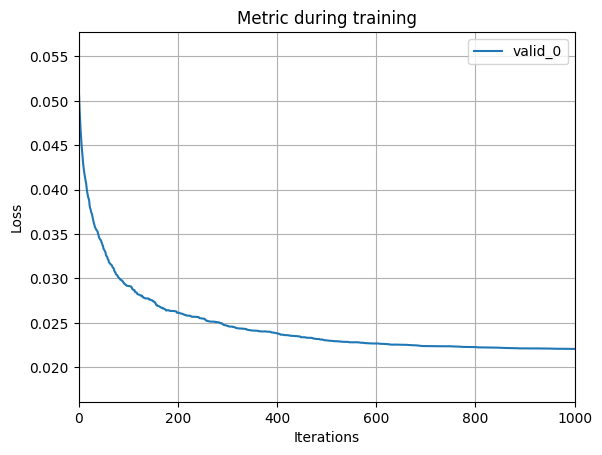

In [188]:
# Select best model
best_result = min(results.items(), key=lambda x: calculate_loss(y_test, x[1][1]))
# Plot the best model
plot_evaluation(y_test, best_result[1][1])
lgb.plot_metric(best_result[1][0], xlabel='Iterations', ylabel='Loss')
best_lgb_predictions = best_result[1][1]
best_booster_type = best_result[0]
loss_at_epoch = best_result[1][0]['valid_0']['l2']
train_duration = best_result[1][2]
params = best_result[1][3]
add_best_of_model(f'LightGBM {best_booster_type}', best_lgb_predictions, loss_at_epoch, train_duration, params)

In [189]:
import torch.nn as nn

class CNNRegressor(nn.Module):
    def __init__(self, n_features, seq_length, n_outputs, n_filters=32, kernel_size=3, pool_size=2, dropout_rate=0.5, hidden_layers=64):
        super(CNNRegressor, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(n_features, n_filters, kernel_size),
            nn.ReLU(),
            nn.MaxPool1d(pool_size),
            nn.Conv1d(n_filters, n_filters, kernel_size),
            nn.ReLU(),
            nn.MaxPool1d(pool_size),
            nn.Dropout(dropout_rate),
            nn.Flatten(),
        )

        self.fc = nn.Sequential(
            nn.Linear(n_filters * ((seq_length - 2*kernel_size)//pool_size**2), hidden_layers),
            nn.ReLU(),
            nn.Linear(hidden_layers, n_outputs)
        )

    def forward(self, x):
        x = x.transpose(1, 2)  # swap time and feature dimensions
        x = self.cnn(x)
        x = self.fc(x)
        return x

In [190]:
class RNNRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, sequence_length):
        super(RNNRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.sequence_length = sequence_length
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, output_size)
        
    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)
        
        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out

In [191]:
import math

# Define the Dense Layer (Bottleneck layer)
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.conv1 = nn.Conv1d(in_channels, 4*growth_rate, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(4*growth_rate)
        self.conv2 = nn.Conv1d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        # print(f'Before x.shape: {x.shape}')
        out = self.conv1(torch.relu(self.bn1(x)))
        # print(f'Conv1 out.shape: {out.shape}')
        out = self.conv2(torch.relu(self.bn2(out)))
        # print(f'Conv2 out.shape: {out.shape}')
        out = torch.cat([out,x], 1)
        # print(f'Final out.shape: {out.shape}')
        return out

# Define the Dense Block
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, n_layers):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList([DenseLayer(in_channels + i*growth_rate, growth_rate) for i in range(n_layers)])

    def forward(self, x):
        for layer in self.layers:
            # print(f'Before x.shape: {x.shape}')
            x = layer(x)
            # print(f'After x.shape: {x.shape}')
        return x

# Define the Transition Layer
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm1d(in_channels)
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.avg_pool = nn.AvgPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.conv(torch.relu(self.bn(x)))
        return self.avg_pool(out)

class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_init_features=64, output_size=1):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv1d(X_train.shape[1], num_planes, kernel_size=3, stride=1, padding=1, bias=False)

        self.dense_blocks = nn.ModuleList()
        self.trans_layers = nn.ModuleList()

        for i in range(len(nblocks)):
            self.dense_blocks.append(self._make_dense_layers(block, num_planes, nblocks[i]))
            num_planes += nblocks[i]*growth_rate
            if i != len(nblocks) - 1:
                out_planes = int(math.floor(num_planes*reduction))
                self.trans_layers.append(TransitionLayer(num_planes, out_planes))
                num_planes = out_planes

        self.bn = nn.BatchNorm1d(num_planes).to(device)
        self.linear = nn.Linear(num_planes, output_size).to(device)

    def _make_dense_layers(self, block, in_planes, nblock):
        return nn.Sequential(*block(in_planes, self.growth_rate, n_layers=nblock).layers)

    def forward(self, x):
        # print(f'Input: {x.shape}')
        out = self.conv1(x)
        for i, (dense_block, trans_layer) in enumerate(zip(self.dense_blocks, self.trans_layers)):
            # print(f'Before dense_blocks[{i}]: {out.shape}')
            out = dense_block(out)
            # print(f'After dense_blocks[{i}]: {out.shape}')
            out = trans_layer(out)
            # print(f'After trans_layers[{i}]: {out.shape}')
        out = self.dense_blocks[-1](out)
        # print(f'After dense_blocks[-1]: {out.shape}')
        out = torch.relu(self.bn(out))
        out = nn.functional.adaptive_avg_pool1d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [192]:
import optuna
import random
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

def train(
    net: nn.Module, 
    criterion, 
    optimizer: optim.Optimizer,
    num_epochs: int, 
    train_loader: DataLoader, 
    device: str, 
    trial: optuna.Trial, 
    early_stopping_rounds: int = -1):
    net.train()
    loss_at_epoch = []
    start_time = time.perf_counter()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.float().to(device), labels.float().to(device)
            
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        trial.report(epoch_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        loss_at_epoch.append(epoch_loss)
        
        # Early stopping check
        epsilon = 1e-4
        if epoch_loss + epsilon < best_loss:
            best_loss = epoch_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == early_stopping_rounds:
                print('Early stopping!')
                end_time = time.perf_counter()
                plot_train(loss_at_epoch)
                return net, loss_at_epoch, end_time - start_time

    end_time = time.perf_counter()
    # Plot the loss at each epoch
    plot_train(loss_at_epoch)
    return net, loss_at_epoch, end_time - start_time

def evaluate(net: nn.Module, criterion, test_loader: DataLoader, device: str):
    net.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        test_loss = 0.0
        for inputs, labels in test_loader:
            inputs, labels = inputs.float().to(device), labels.float().to(device)
            outputs = net(inputs)

            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item()

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
            
    plot_evaluation(actuals, predictions)

    return predictions, actuals, test_loss/len(test_loader)

In [193]:
def train_and_eval_dnn(trial: optuna.Trial):
    growth_rate = trial.suggest_int('growth_rate', 4, 12)
    reduction = trial.suggest_float('reduction', 0.5, 0.9)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    nblocks = [trial.suggest_int('nblocks1', 4, 8),
               trial.suggest_int('nblocks2', 8, 16),
               trial.suggest_int('nblocks3', 16, 32),]

    net = DenseNet(DenseBlock, nblocks, growth_rate=growth_rate, reduction=reduction, output_size=1).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    num_epochs = 40

    net, loss_at_epoch, duration = train(net, criterion, optimizer, num_epochs, train_loader, device, trial, early_stopping_rounds=5)
    predictions, actuals, test_loss = evaluate(net, criterion, test_loader, device)
    
    trial.set_user_attr('predictions', predictions)
    trial.set_user_attr('loss_at_epoch', loss_at_epoch)
    trial.set_user_attr('duration', duration)

    return test_loss

In [194]:
def train_and_eval_rnn(trial: optuna.Trial):
    # Hyperparameters
    input_size = X_train.shape[2]
    output_size = 1
    sequence_length = X_train.shape[1]
    
    num_layers = 128
    hidden_size = 24
    learning_rate = 1e-5
    
    print(f'X_train.shape: {X_train.shape}')
    
    model = RNNRegressor(input_size, hidden_size, num_layers, output_size, sequence_length).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    num_epochs = 40

    model, loss_at_epoch, duration = train(model, criterion, optimizer, num_epochs, train_loader, device, trial, early_stopping_rounds=5)
    predictions, actuals, test_loss = evaluate(model, criterion, test_loader, device)
    
    trial.set_user_attr('predictions', predictions)
    trial.set_user_attr('loss_at_epoch', loss_at_epoch)
    trial.set_user_attr('duration', duration)

    return test_loss

In [195]:
def train_and_eval_cnn(trial: optuna.Trial): # Suggest hyperparameters using the trial object
    num_filters = trial.suggest_int("num_filters", 64, 512, step=32)
    kernel_size = trial.suggest_int("kernel_size", 3, 3)
    pool_size = trial.suggest_int("pool_size", 2, 2)
    hidden_layers = trial.suggest_int("hidden_layers", 24, 92, step=8)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.3, step=0.05)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    # num_filters = 437
    # kernel_size = 4
    # pool_size = 4
    # hidden_units = 73
    # dropout_rate = 0.1657660256105821
    # learning_rate = 3.964884325777312e-05
    
    print(f'X_train.shape: {X_train.shape}')
    input_channels = X_train.shape[2]
    sequence_length = X_train.shape[1]
    n_outputs = 1
    net = CNNRegressor(input_channels, sequence_length, n_outputs, num_filters, kernel_size, pool_size, dropout_rate, hidden_layers).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    num_epochs = 100

    net, loss_at_epoch, duration = train(net, criterion, optimizer, num_epochs, train_loader, device, trial, early_stopping_rounds=5)
    predictions, actuals, test_loss = evaluate(net, criterion, test_loader, device)
    
    trial.set_user_attr('predictions', predictions)
    trial.set_user_attr('loss_at_epoch', loss_at_epoch)
    trial.set_user_attr('duration', duration)

    return test_loss

## Hyperparameter optimization via Optuna

In [196]:
def optimize_model(model_name: str, train_and_eval_func, n_trials: int):
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42), pruner=optuna.pruners.HyperbandPruner())
    study.optimize(train_and_eval_func, n_trials=n_trials)
    
    # Get the best 5 trials
    completed_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
    best_trials = sorted(completed_trials, key=lambda t: t.value)[:5]

    # Print the best 5 trials' parameters and their respective values
    for i, trial in enumerate(best_trials):
        print(f"Best trial {i + 1}:")
        print(f"\tValue: {trial.value}")
        print(f"\tParams: {trial.params}")
        
    # Get the best trial
    best_trial = study.best_trial
    # Add best trial to the best of models
    add_best_of_model(
        model_name, 
        best_trial.user_attrs['predictions'],
        best_trial.user_attrs['loss_at_epoch'],
        best_trial.user_attrs['duration'],
        best_trial.params)

In [203]:
n_trials = 40
optimize_model('CNN', train_and_eval_cnn, n_trials)
optimize_model('DNN', train_and_eval_dnn, n_trials)
optimize_model('RNN', train_and_eval_rnn, n_trials)

[I 2023-05-20 23:18:45,833] A new study created in memory with name: no-name-4483e984-0662-4ce4-8157-dd0e73e50bd9


X_train.shape: (24512, 100, 25)


[W 2023-05-20 23:18:49,865] Trial 0 failed with parameters: {} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\illya\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\illya\AppData\Local\Temp\ipykernel_7588\2544496164.py", line 19, in train_and_eval_rnn
    model, loss_at_epoch, duration = train(model, criterion, optimizer, num_epochs, train_loader, device, trial)
                                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\illya\AppData\Local\Temp\ipykernel_7588\2834369339.py", line 17, in train
    outputs = net(inputs)
              ^^^^^^^^^^^
  File "c:\Users\illya\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)

KeyboardInterrupt: 

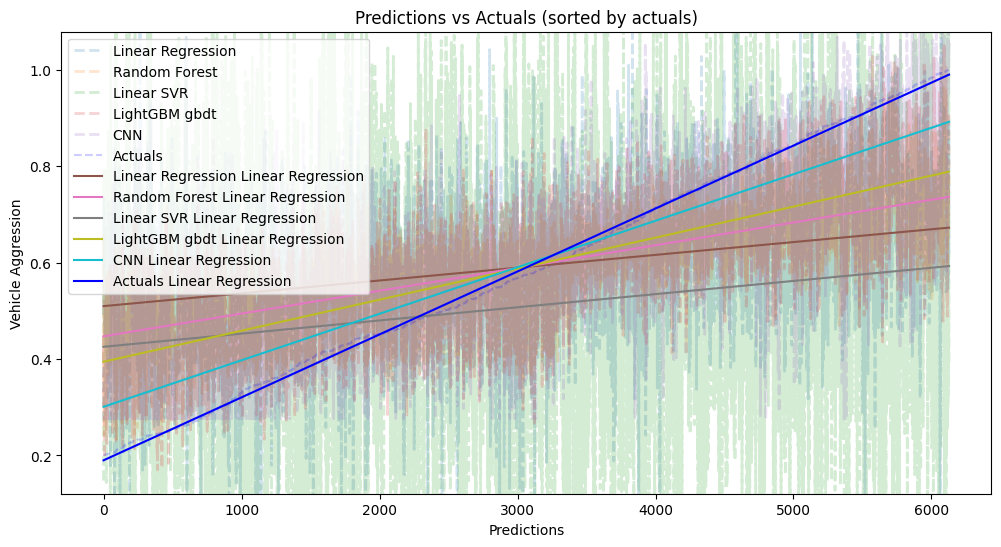

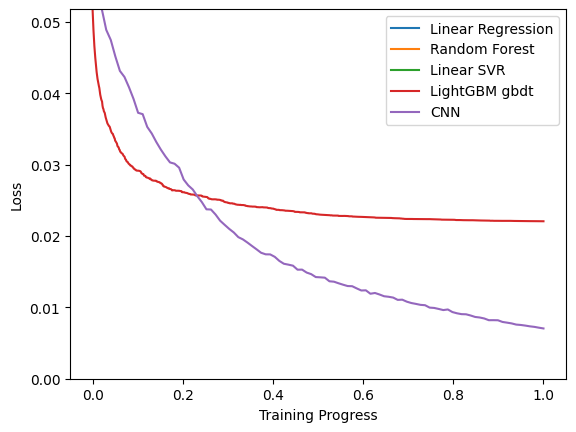

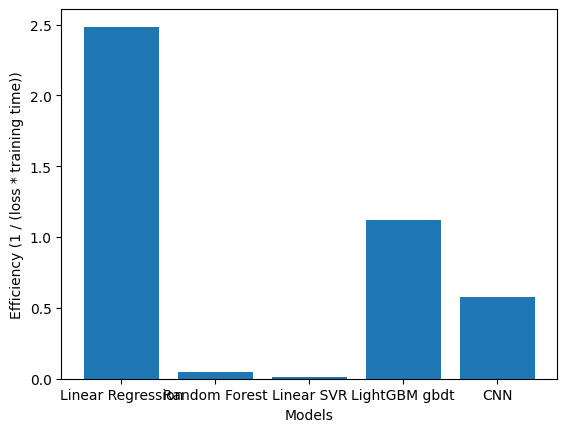

In [202]:
best_predictions = {}
for model, result in best_of_models.items():
    best_predictions[model] = result['predictions']
plot_evaluations(y_test, best_predictions)

best_losses_at_epoch = {}
for model, result in best_of_models.items():
    best_losses_at_epoch[model] = result['loss_at_epoch']
plot_trains(best_losses_at_epoch)

best_losses = {}
best_training_times = {}
for model, result in best_of_models.items():
    best_losses[model] = result['loss']
    best_training_times[model] = result['training_time']
plot_train_efficiencies(best_losses, best_training_times)